In [1426]:
# libraries used 
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [1476]:
#importing data
ticker= ['NVDA','AAPL', 'MSFT', 'AMZN', 'GOOG', 'META', 'TSLA', 'BRK-B', 'AVGO', 'WMT', 'LLY', 'JPM', 'V', 'UNH', 'XOM', 'ORCL', 'MA', 'COST', 'HD', 'PG', 'NFLX' ]
target_tickers= ['V','UNH', 'XOM', 'ORCL' ,'MA']
index=4
#ticker = target_tickers


# NVDA: 2
# AAPL: avg of last 2/3 days 
# MSFT: 4
# AMZN: avg of last 3/4/5 days +2 
# GOOG: avg of last 3/4/5
# meta avg of 2/3 days
# BRB-k 2
# wmt 4
# netflix: avg of last 2/3/4 days 



stock_data= yf.download(ticker[index], start="2024-11-1", end="2024-12-1")


#getting data of interest for stockk data
closing_prices= stock_data['Close'][ticker[index]].tolist()
opening_prices= stock_data['Open'][ticker[index]].tolist()
highs= stock_data['High'][ticker[index]].tolist()
lows= stock_data['Low'][ticker[index]].tolist()
AdjClose= stock_data['Adj Close'][ticker[index]].tolist()

#making a dataframe using the values fetched above 
stock_df= pd.DataFrame(columns=['High'])#, 'High', 'Low', 'Close', 'AdjClose'])
stock_df['High']= closing_prices

# processing the data

def log_transform(df):
    columns= df.columns
    transformed_df = df.copy()
    for col in columns:
        transformed_df[col] = np.log(transformed_df[col])  # log1p handles log(x + 1)
    return transformed_df

def reverse_transform(df):
    columns= df.columns
    reversed_df = df.copy()
    for col in columns:
        reversed_df[col] = np.expm1(reversed_df[col])  # Exponential minus 1
    return reversed_df
    

stock_df_transformed= log_transform(stock_df)


[*********************100%***********************]  1 of 1 completed


In [1477]:
closing_prices

[172.64999389648438,
 170.67999267578125,
 171.41000366210938,
 178.3300018310547,
 182.27999877929688,
 179.86000061035156,
 181.97000122070312,
 183.32000732421875,
 180.49000549316406,
 177.35000610351562,
 173.88999938964844,
 176.8000030517578,
 179.5800018310547,
 177.3300018310547,
 169.24000549316406,
 166.57000732421875,
 169.42999267578125,
 170.6199951171875,
 170.82000732421875,
 170.49000549316406]

# LSTM Model

Epoch 1/20


/Users/pranavsharma/Desktop/VS/StockMarketAnanlysis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.1103 - val_loss: 0.0655
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0107 - val_loss: 0.0093
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0130 - val_loss: 0.0421
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0095 - val_loss: 0.0445
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060 - val_loss: 0.0166
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - val_loss: 0.0143
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058 - val_loss: 0.0242
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 0.0179
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 0.0135
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 0.0145
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - val_loss: 0.0134
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.0110
Epoch 13/20


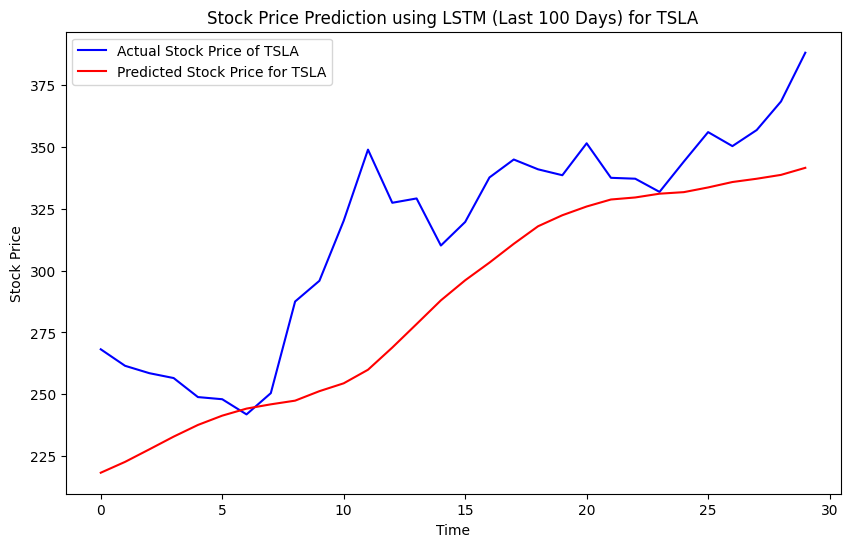

In [1428]:
# Assuming your dataframe is called stock_df_transformed
# Get the 'close' prices
stock_data = stock_df_transformed['High'].values

# Step 1: Normalize the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data_scaled = scaler.fit_transform(stock_data.reshape(-1, 1))

# Step 2: Create sequences for training
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # past 'time_step' days
        y.append(data[i + time_step, 0])  # next day's price
    return np.array(X), np.array(y)

time_step = 10  # Look back over the past 90 days
X, y = create_dataset(stock_data_scaled, time_step)

# Reshape X to be compatible with LSTM input shape (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer for predicted stock price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 6: Predict stock prices
predicted_stock_price = model.predict(X_test)

# Reverse the scaling for the predictions and test data
predicted_stock_price = np.expm1(scaler.inverse_transform(predicted_stock_price))
y_test_actual = np.expm1(scaler.inverse_transform(y_test.reshape(-1, 1)))

# # Step 7: Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_actual, color='blue', label=f'Actual Stock Price of {ticker[index]}')
# plt.plot(predicted_stock_price, color='red', label=f'Predicted Stock Price for {ticker[index]}')
# plt.title(f'Stock Price Prediction using LSTM for {ticker[index]}')
# plt.xlabel('Time')
# plt.ylabel('Stock Price')
# plt.legend()
# plt.show()

# Slice the last 100 data points for both actual and predicted prices
last_100_actual = y_test_actual[-30:]
last_100_predicted = predicted_stock_price[-30:]

# Plot the results for the last 100 days
plt.figure(figsize=(10, 6))
plt.plot(last_100_actual, color='blue', label=f'Actual Stock Price of {ticker[index]}')
plt.plot(last_100_predicted, color='red', label=f'Predicted Stock Price for {ticker[index]}')
plt.title(f'Stock Price Prediction using LSTM (Last 100 Days) for {ticker[index]}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



In [1429]:
# Assuming stock_df_transformed is already prepared and contains the 'Close' prices.

# Get the latest 5 days of stock data (last 5 rows)
latest_data = stock_df_transformed['High'].values[-2:]
# Step 1: Noxrmalize the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
latest_data_scaled = scaler.fit_transform(latest_data.reshape(-1, 1))

# Reshape the data to be compatible with the LSTM model
latest_data = latest_data.reshape(1, -1)
latest_data = latest_data.reshape((latest_data.shape[0], latest_data.shape[1], 1))

# Predict the next day's stock price using the trained model
predicted_next_day_price = model.predict(latest_data)

# Reverse the scaling of the predicted price to return it to the original scale
predicted_next_day_price = np.expm1(scaler.inverse_transform(predicted_next_day_price))

# Print the predicted next day's price

print(f"Predicted next day's price: {predicted_next_day_price[0][0]}")
last2 = predicted_next_day_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Predicted next day's price: 388.74444580078125


In [1430]:
# Assuming stock_df_transformed is already prepared and contains the 'Close' prices.

# Get the latest 5 days of stock data (last 5 rows)
latest_data = stock_df_transformed['High'].values[-3:]
# Step 1: Noxrmalize the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
latest_data_scaled = scaler.fit_transform(latest_data.reshape(-1, 1))

# Reshape the data to be compatible with the LSTM model
latest_data = latest_data.reshape(1, -1)
latest_data = latest_data.reshape((latest_data.shape[0], latest_data.shape[1], 1))

# Predict the next day's stock price using the trained model
predicted_next_day_price = model.predict(latest_data)

# Reverse the scaling of the predicted price to return it to the original scale
predicted_next_day_price = np.expm1(scaler.inverse_transform(predicted_next_day_price))

# Print the predicted next day's price

print(f"Predicted next day's price: {predicted_next_day_price[0][0]}")
last3 = predicted_next_day_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted next day's price: 399.7463073730469


In [1431]:
# Assuming stock_df_transformed is already prepared and contains the 'Close' prices.

# Get the latest 5 days of stock data (last 5 rows)
latest_data = stock_df_transformed['High'].values[-4:]
# Step 1: Normalize the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
latest_data_scaled = scaler.fit_transform(latest_data.reshape(-1, 1))

# Reshape the data to be compatible with the LSTM model
latest_data = latest_data.reshape(1, -1)
latest_data = latest_data.reshape((latest_data.shape[0], latest_data.shape[1], 1))

# Predict the next day's stock price using the trained model
predicted_next_day_price = model.predict(latest_data)

# Reverse the scaling of the predicted price to return it to the original scale
predicted_next_day_price = np.expm1(scaler.inverse_transform(predicted_next_day_price))

# Print the predicted next day's price

print(f"Predicted next day's price: {predicted_next_day_price[0][0]}")
last4 = predicted_next_day_price

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted next day's price: 424.9840393066406


In [1432]:
# Assuming stock_df_transformed is already prepared and contains the 'Close' prices.

# Get the latest 5 days of stock data (last 5 rows)
latest_data = stock_df_transformed['High'].values[-5:]
# Step 1: Normalize the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
latest_data_scaled = scaler.fit_transform(latest_data.reshape(-1, 1))

# Reshape the data to be compatible with the LSTM model
latest_data = latest_data.reshape(1, -1)
latest_data = latest_data.reshape((latest_data.shape[0], latest_data.shape[1], 1))

# Predict the next day's stock price using the trained model
predicted_next_day_price = model.predict(latest_data)

# Reverse the scaling of the predicted price to return it to the original scale
predicted_next_day_price = np.expm1(scaler.inverse_transform(predicted_next_day_price))

# Print the predicted next day's price

print(f"Predicted next day's price: {predicted_next_day_price[0][0]}")
last5 = predicted_next_day_price

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted next day's price: 451.7679748535156


In [1433]:
stock_data= yf.download(ticker[index], start="2023-11-1", end="2024-12-12")

[*********************100%***********************]  1 of 1 completed


In [1434]:
stock_data

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2023-11-01,205.660004,205.660004,205.990005,197.850006,204.039993,121661700
2023-11-02,218.509995,218.509995,219.199997,211.449997,212.970001,125987600
2023-11-03,219.960007,219.960007,226.369995,218.399994,221.149994,119281000
2023-11-06,219.270004,219.270004,226.320007,215.000000,223.979996,117335800
2023-11-07,222.179993,222.179993,223.119995,215.720001,219.979996,116900100
...,...,...,...,...,...,...
2024-12-05,369.489990,369.489990,375.429993,359.500000,359.869995,81403600
2024-12-06,389.220001,389.220001,389.489990,370.799988,377.420013,81455800


In [1435]:
last2

array([[388.74445]], dtype=float32)

In [1436]:
99(last2+ last3)/2

<>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
/var/folders/k1/k9yjwyjj6txbvvlybvf7xp1w0000gn/T/ipykernel_991/1861066485.py:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  99(last2+ last3)/2


TypeError: 'int' object is not callable

In [1438]:
(last3+last5)/2

array([[425.75714]], dtype=float32)

In [1437]:
last4

array([[424.98404]], dtype=float32)

# model 2

In [ ]:
stock_data= yf.download(ticker[index], start="2024-11-21", end="2024-12-12")

[*********************100%***********************]  1 of 1 completed


In [ ]:

dates= stock_data.index[-10:]

In [ ]:
stock_df_prophet= pd.DataFrame(columns=['Close'])
stock_df_prophet.Close= closing_prices[-10:]
stock_df_prophet.index= dates
stock_df_prophet.describe

<bound method NDFrame.describe of                  Close
Date                  
2024-11-27  338.230011
2024-11-29  332.890015
2024-12-02  345.160004
2024-12-03  357.089996
2024-12-04  351.420013
2024-12-05  357.929993
2024-12-06  369.489990
2024-12-09  389.220001
2024-12-10  389.790009
2024-12-11  400.989990>

In [ ]:
import pandas as pd
from prophet import Prophet

# Load data
df = pd.DataFrame({'ds': dates, 'y': stock_df_prophet['Close']})

# Initialize and fit the model
model = Prophet()
model.fit(df)



19:38:23 - cmdstanpy - INFO - Chain [1] start processing


19:38:23 - cmdstanpy - INFO - Chain [1] done processing


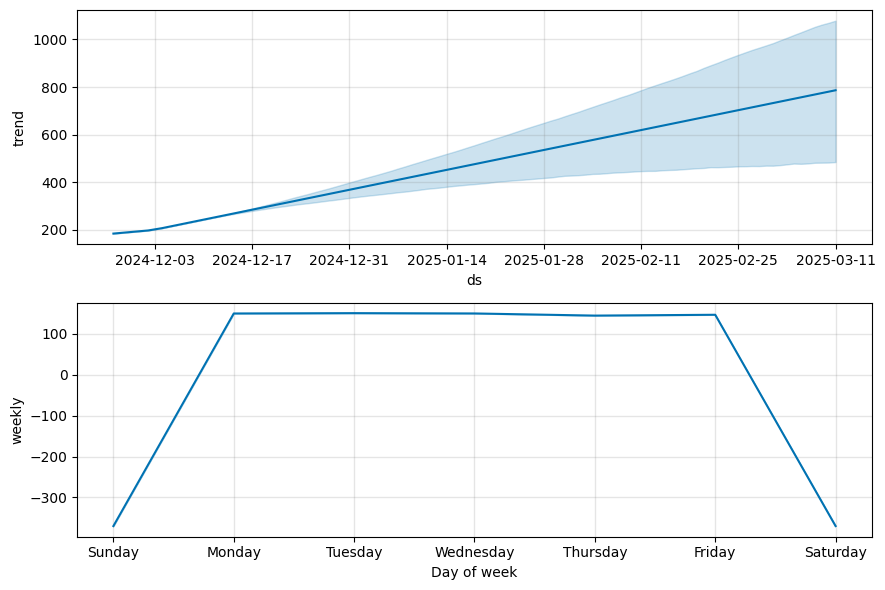

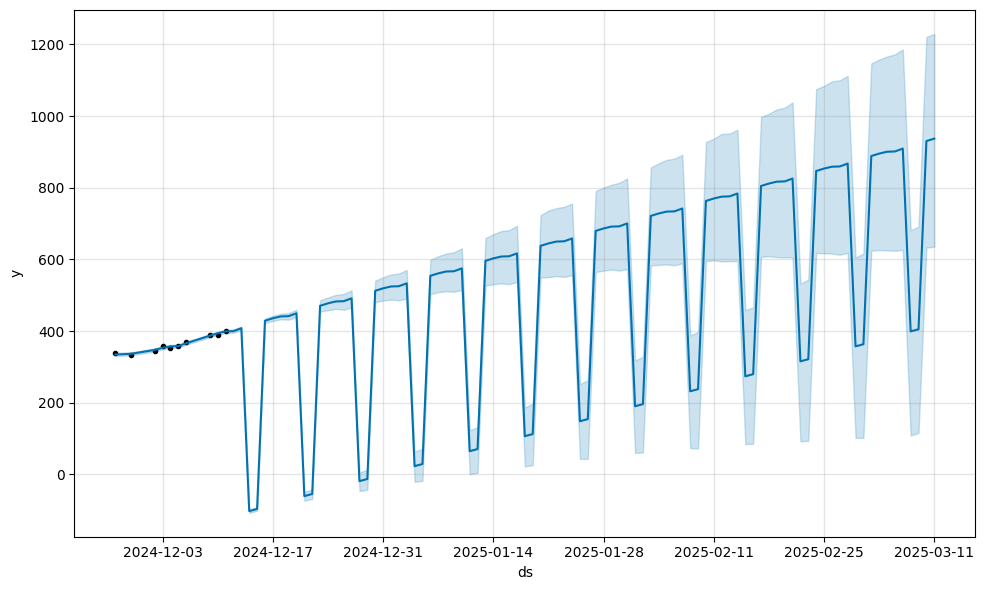

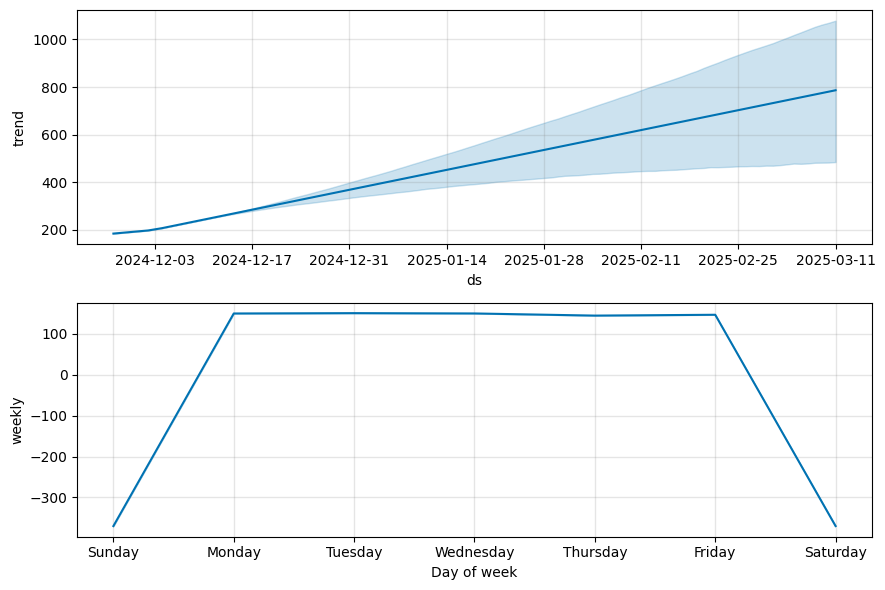

In [ ]:
# Create future dates for prediction
future = model.make_future_dataframe(periods=90)  # Predict the next 30 days
forecast = model.predict(future)

# Visualize the results
model.plot(forecast)
model.plot_components(forecast)

In [ ]:
# Create a DataFrame for the next day
future = model.make_future_dataframe(periods=1)

# Predict
forecast = model.predict(future)

# Extract the next day's prediction
next_day_forecast = forecast.iloc[-1]  # Last row corresponds to the next day
predicted_price = next_day_forecast['yhat']  # Central prediction
print(f"Predicted next day price: {predicted_price}")


Predicted next day price: 399.7245899132914


In [ ]:
total= last4+predicted_price
total/2


array([[413.75476627]])

In [ ]:
future

,ds
0,2024-11-27
1,2024-11-29
2,2024-12-02
3,2024-12-03
4,2024-12-04
5,2024-12-05
6,2024-12-06
7,2024-12-09
8,2024-12-10
9,2024-12-11


In [ ]:
forecast.iloc[-7:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4,2024-12-04,207.673895,352.765313,361.234801,207.673895,207.673895,149.526420,149.526420,149.526420,149.526420,149.526420,149.526420,0.0,0.0,0.0,357.200315
5,2024-12-05,213.644623,353.869294,362.087895,213.644623,213.644623,144.284539,144.284539,144.284539,144.284539,144.284539,144.284539,0.0,0.0,0.0,357.929162
6,2024-12-06,219.615399,361.300911,370.303808,219.615399,219.615399,146.323356,146.323356,146.323356,146.323356,146.323356,146.323356,0.0,0.0,0.0,365.938755
7,2024-12-09,237.527725,382.407941,391.527517,237.527725,237.527725,149.459681,149.459681,149.459681,149.459681,149.459681,149.459681,0.0,0.0,0.0,386.987406
8,2024-12-10,243.498500,389.278946,397.999568,243.498500,243.498500,150.288732,150.288732,150.288732,150.288732,150.288732,150.288732,0.0,0.0,0.0,393.787232
9,2024-12-11,249.469275,394.543451,403.540337,249.469275,249.469275,149.526420,149.526420,149.526420,149.526420,149.526420,149.526420,0.0,0.0,0.0,398.995695
10,2024-12-12,255.440051,395.083305,404.392656,254.873425,255.966360,144.284539,144.284539,144.284539,144.284539,144.284539,144.284539,0.0,0.0,0.0,399.724590


In [ ]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [1439]:
# final analysis 

In [1441]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Load Apple stock data
start_train = "2023-10-01"
end_train = "2024-10-31"
start_test = "2024-11-01"
end_test = "2024-11-30"

data = yf.download('AAPL', start=start_train, end=end_test)
data_train = data.loc[start_train:end_train]
data_test = data.loc[start_test:end_test]


[*********************100%***********************]  1 of 1 completed


In [1443]:

# Use the 'Close' prices for training and prediction
train_prices = data_train['Close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))

# Create sequences for LSTM

def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_train, y_train = create_dataset(train_prices_scaled, time_step)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 2. Test model on November 2024 data
actual_prices = data_test['Close'].values
rolling_predictions = []

# Normalize test data for rolling prediction
scaled_test = scaler.transform(actual_prices.reshape(-1, 1))

# Perform rolling predictions
for i in range(len(scaled_test) - time_step):
    input_data = scaled_test[i:i + time_step].reshape(1, time_step, 1)
    pred = model.predict(input_data)
    rolling_predictions.append(pred[0][0])

# Reverse scaling of predictions
rolling_predictions = scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1)).flatten()


Epoch 1/20


/Users/pranavsharma/Desktop/VS/StockMarketAnanlysis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2127
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

In [ ]:
# Flatten actual prices to 1-dimensional
actual_prices = actual_prices[time_step:].flatten() if actual_prices.ndim > 1 else actual_prices

# Create the DataFrame with properly aligned shapes
results = pd.DataFrame({
    'Actual': actual_prices,
    'Predicted': rolling_predictions
})


Actual prices shape: (0,)
Predicted prices shape: (11,)


Mean Absolute Error (MAE): 2.796125793457031
Mean Absolute Percentage Error (MAPE): 1.20%


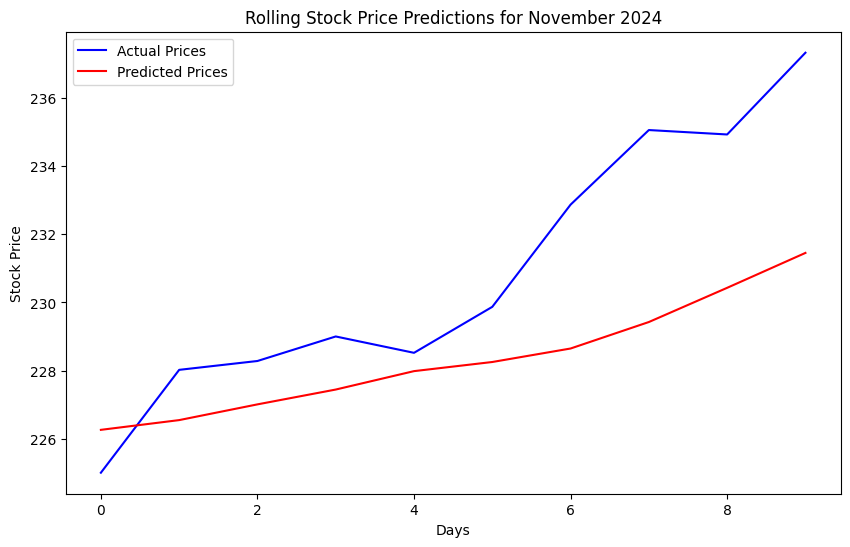

In [1446]:

# 3. Evaluation using MAE and MAPE
mae = mean_absolute_error(results['Actual'], results['Predicted'])
mape = mean_absolute_percentage_error(results['Actual'], results['Predicted'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results['Actual'], label='Actual Prices', color='blue')
plt.plot(results['Predicted'], label='Predicted Prices', color='red')
plt.title('Rolling Stock Price Predictions for November 2024')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [1447]:
rolling_predictions

array([226.25888, 226.54468, 227.00652, 227.44179, 227.98239, 228.25047,
       228.64659, 229.4241 , 230.42818, 231.4529 ], dtype=float32)

In [1459]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Load Apple stock data
start_train = "2023-10-01"
end_train = "2024-10-31"
start_test = "2024-11-01"
end_test = "2024-11-30"

data = yf.download('AAPL', start=start_train, end=end_test)
data_train = data.loc[start_train:end_train]
data_test = data.loc[start_test:end_test]

# Use the 'Close' prices for training and prediction
train_prices = data_train['Close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))

# Create sequences for LSTM
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_train, y_train = create_dataset(train_prices_scaled, time_step)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 2. Test model on November 2024 data
actual_prices = data_test['Close'].values
rolling_predictions = []

# Normalize test data for rolling prediction
scaled_test = scaler.transform(actual_prices.reshape(-1, 1))

# Perform rolling predictions for all days in November
for i in range(len(scaled_test) - time_step + 1):
    input_data = scaled_test[i:i + time_step].reshape(1, time_step, 1)
    pred = model.predict(input_data)
    rolling_predictions.append(pred[0][0])

# Reverse scaling of predictions
rolling_predictions = scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1)).flatten()


[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/Users/pranavsharma/Desktop/VS/StockMarketAnanlysis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2311
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0240 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0147 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0073 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

In [1460]:
# Flatten actual prices to 1-dimensional
actual_prices = actual_prices[time_step:].flatten() if actual_prices.ndim > 1 else actual_prices

# Create the DataFrame with properly aligned shapes
results = pd.DataFrame({
    'Actual': actual_prices,
    'Predicted': rolling_predictions
})

# 3. Evaluation using MAE and MAPE
mae = mean_absolute_error(results['Actual'], results['Predicted'])
mape = mean_absolute_percentage_error(results['Actual'], results['Predicted'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results['Actual'], label='Actual Prices', color='blue')
plt.plot(results['Predicted'], label='Predicted Prices', color='red')
plt.title('Rolling Stock Price Predictions for November 2024')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

ValueError: All arrays must be of the same length

In [1462]:
len(rolling_predictions)

11

In [1465]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Load Apple stock data
start_train = "2023-10-01"
end_train = "2024-10-31"
start_test = "2024-11-01"
end_test = "2024-11-30"

data = yf.download('AAPL', start=start_train, end=end_test)
data_train = data.loc[start_train:end_train]
data_test = data.loc[start_test:end_test]

# Use the 'Close' prices for training and prediction
train_prices = data_train['Close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))

# Create sequences for LSTM
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_train, y_train = create_dataset(train_prices_scaled, time_step)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 2. Test model on November 2024 data
actual_prices = data_test['Close'].values
rolling_predictions = []

# Normalize test data for rolling prediction
scaled_test = scaler.transform(actual_prices.reshape(-1, 1))

# Perform rolling predictions for all days in November
input_data = scaled_test[:time_step].reshape(1, time_step, 1)  # Initial input data
# Adjust the rolling prediction loop to cover all November days
for i in range(len(actual_prices) - time_step):
    pred = model.predict(input_data)
    rolling_predictions.append(pred[0][0])
    # Update input data with the new prediction
    new_input = np.append(input_data[0, 1:, 0], pred[0][0])
    input_data = new_input.reshape(1, time_step, 1)

# Reverse scaling of predictions
rolling_predictions = scaler.inverse_transform(np.array(rolling_predictions).reshape(-1, 1)).flatten()

# Align actual prices and rolling predictions
actual_prices_adjusted = actual_prices[time_step:len(rolling_predictions) + time_step]
# Flatten actual prices to 1-dimensional
actual_prices = actual_prices[time_step:].flatten() if actual_prices.ndim > 1 else actual_prices
# Store predictions and actual values in a DataFrame
results = pd.DataFrame({
    'Actual': actual_prices_adjusted,
    'Predicted': rolling_predictions
})

# 3. Evaluation using MAE and MAPE
mae = mean_absolute_error(results['Actual'], results['Predicted'])
mape = mean_absolute_percentage_error(results['Actual'], results['Predicted'])

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results['Actual'], label='Actual Prices', color='blue')
plt.plot(results['Predicted'], label='Predicted Prices', color='red')
plt.title('Rolling Stock Price Predictions for November 2024')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/Users/pranavsharma/Desktop/VS/StockMarketAnanlysis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2277
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0286 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0138 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

ValueError: Per-column arrays must each be 1-dimensional